In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
plt.rcParams['font.family'] = 'AppleGothic'
warnings.filterwarnings('ignore')
df = pd.read_csv('피처추가함.csv')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91824 entries, 0 to 91823
Columns: 173 entries, 기준년월 to 이자원금_30일초과연체과목수
dtypes: float64(42), int64(130), object(1)
memory usage: 121.2+ MB


In [24]:
df['단기차입금의존도'] = df['단기차입금'] / df['자산총계'].replace(0, np.nan) #자산총계 0 인것이 3개


# 현금성비율 = 현금 / 유동부채
df['현금성비율'] = df['현금'] / df['유동부채'].replace(0, np.nan)

# 단기순차입금 = 단기차입금 - 현금
df['단기순차입금'] = df['단기차입금'] - df['현금']

# 순운전자본 = 유동자산 - 유동부
df['순운전자본'] = df['유동자산'] - df['유동부채']


#결측치 처리
df['현금성비율'] = df['현금성비율'].fillna(0)
df = df[df['자산총계'] != 0]

# 높을 수록
df['총자본회전율'] = df['매출액'] / df['자산총계'].replace(0, np.nan)



In [13]:
df.to_csv('피처 더 추가함.csv', index=False)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
target_col = '부도여부'

# 문자열 컬럼 인코딩
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# 피처와 타겟 분리
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

# ⚠️ 무한값과 결측값 처리
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습/테스트 셋 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("📊 클래스 가중치:", class_weight_dict)


📊 클래스 가중치: {0: 0.515147477524229, 1: 17.004398148148148}


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 모델 정의
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall()])


2025-07-10 16:01:48.009448: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-07-10 16:01:48.009810: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-10 16:01:48.009816: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-07-10 16:01:48.010059: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-10 16:01:48.010085: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# 클래스 가중치
class_weights = {0: 0.506717384266753, 1: 37.71686746987952}

# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ],
    verbose=1
)


Epoch 1/30


2025-07-10 16:01:50.660492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-07-10 16:01:50.668603: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


919/919 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.3358 - auc: 0.7012 - loss: 0.9779 - recall: 0.8822 - val_accuracy: 0.5546 - val_auc: 0.8260 - val_loss: 0.7511 - val_recall: 0.9089
Epoch 2/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.5246 - auc: 0.8075 - loss: 0.7501 - recall: 0.9291 - val_accuracy: 0.5491 - val_auc: 0.8351 - val_loss: 0.7426 - val_recall: 0.9367
Epoch 3/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.5397 - auc: 0.8274 - loss: 0.7082 - recall: 0.9398 - val_accuracy: 0.5515 - val_auc: 0.8357 - val_loss: 0.7003 - val_recall: 0.9241
Epoch 4/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.5546 - auc: 0.8390 - loss: 0.6754 - recall: 0.9430 - val_accuracy: 0.5926 - val_auc: 0.8485 - val_loss: 0.6406 - val_recall: 0.9038
Epoch 5/30
919/919 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.5561 - auc: 0.8379 - loss: 0.6821 - recall: 0.9376 - val_accuracy: 0.5404 - val_auc: 0.8485 - val_loss: 0.7008 - val_recall: 0.9468
Epoch 6/30


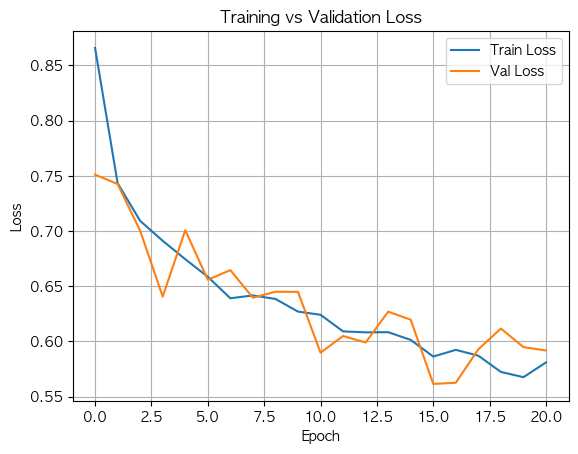

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

# 예측
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# 출력
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


 27/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step    

2025-07-10 16:08:21.882265: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[11160  6665]
 [   54   486]]
              precision    recall  f1-score   support

           0     0.9952    0.6261    0.7686     17825
           1     0.0680    0.9000    0.1264       540

    accuracy                         0.6341     18365
   macro avg     0.5316    0.7630    0.4475     18365
weighted avg     0.9679    0.6341    0.7497     18365



In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping

# 모델 구성
model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# 옵티마이저: 진동 완화에 효과적인 Nadam
optimizer = Nadam(learning_rate=0.001)

# 모델 컴파일
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['Recall', 'Precision', 'AUC']
)

# 얼리스타핑 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weights,  # 앞에서 계산한 클래스 가중치
    verbose=1
)


Epoch 1/200


2025-07-10 16:13:06.182814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1148/1148 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - AUC: 0.7168 - Precision: 0.0438 - Recall: 0.8256 - loss: 0.9708 - val_AUC: 0.8166 - val_Precision: 0.0571 - val_Recall: 0.9148 - val_loss: 0.7218
Epoch 2/200
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 44s 39ms/step - AUC: 0.8040 - Precision: 0.0528 - Recall: 0.9245 - loss: 0.7502 - val_AUC: 0.8309 - val_Precision: 0.0586 - val_Recall: 0.9093 - val_loss: 0.7135
Epoch 3/200
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 44s 39ms/step - AUC: 0.8237 - Precision: 0.0578 - Recall: 0.9414 - loss: 0.7080 - val_AUC: 0.8388 - val_Precision: 0.0538 - val_Recall: 0.9611 - val_loss: 0.7796
Epoch 4/200
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 45s 39ms/step - AUC: 0.8320 - Precision: 0.0557 - Recall: 0.9529 - loss: 0.6860 - val_AUC: 0.8305 - val_Precision: 0.0609 - val_Recall: 0.9093 - val_loss: 0.6528
Epoch 5/200
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 45s 39ms/step - AUC: 0.8438 - Precision: 0.0585 - Recall: 0.9561 - loss: 0.6599 - val_AUC: 0.8388 - val_Precision: 0.0636 - val_Recall: 0.9037 - val_

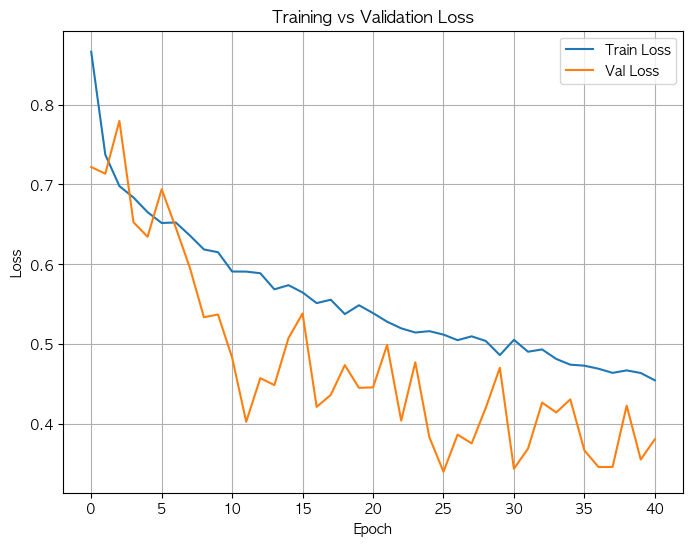

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
from sklearn.metrics import classification_report, confusion_matrix

# 예측 (확률값 → 0/1 이진 변환)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# 혼동 행렬
print("🔹 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 분류 리포트
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


2025-07-10 16:41:56.640162: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
🔹 Confusion Matrix:
[[15121  2704]
 [  197   343]]

🔹 Classification Report:
              precision    recall  f1-score   support

           0     0.9871    0.8483    0.9125     17825
           1     0.1126    0.6352    0.1912       540

    accuracy                         0.8420     18365
   macro avg     0.5499    0.7417    0.5519     18365
weighted avg     0.9614    0.8420    0.8913     18365



In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# CSV 파일 불러오기 (현재 경로에 있는 df_건설.csv 기준)
df = pd.read_csv("피처 더 추가함.csv")

# 타겟 컬럼 정의
target_col = '부도여부'  # 실제 부도 컬럼명으로 교체 필요할 수도 있음
X = df.drop(columns=[target_col])
y = df[target_col]

# 문자형 컬럼 제거 (예: 업종(대분류) 등)
X = X.select_dtypes(include=[np.number])

# 결측치 처리 (모두 0으로 대체, 다른 방식 원하면 알려줘)
X.fillna(0, inplace=True)

# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# 정상 클래스만 추출 (부도 아님: 0)
X_normal = X_scaled[y == 0]

# 오토인코더 모델 정의 (입력 크기 기반)
input_dim = X_normal.shape[1]

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='mse')

# 콜백 설정
early_stop = callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# 학습
history = autoencoder.fit(
    X_normal, X_normal,
    epochs=100,
    batch_size=256,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


2025-07-10 16:54:04.277913: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


349/349 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7632
Epoch 2/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.5367
Epoch 3/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.4226
Epoch 4/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.4246
Epoch 5/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.3760
Epoch 6/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3476
Epoch 7/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.3572
Epoch 8/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2885
Epoch 9/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.2708
Epoch 10/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2659
Epoch 11/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2381
Epoch 12/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2378
Epoch 13/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2585
Epoch 14/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2268
Epoch 15/100
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 모든 데이터에 대해 재구성 (예측)
X_pred = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(np.square(X_scaled - X_pred), axis=1)

# 재구성 오차 기준 임계값 설정 (정상 데이터의 95% 수준)
threshold = np.percentile(reconstruction_error[y == 0], 95)
print(f"🔸 재구성 오차 임계값: {threshold:.4f}")

# 이상 여부 판별
y_pred = (reconstruction_error > threshold).astype(int)

# 성능 평가
print("\n🔹 Confusion Matrix:")
print(confusion_matrix(y, y_pred))

print("\n🔹 Classification Report:")
print(classification_report(y, y_pred, digits=4))


2025-07-10 16:57:18.296581: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


2870/2870 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
🔸 재구성 오차 임계값: 0.4112

🔹 Confusion Matrix:
[[84667  4457]
 [ 2329   371]]

🔹 Classification Report:
              precision    recall  f1-score   support

           0     0.9732    0.9500    0.9615     89124
           1     0.0768    0.1374    0.0986      2700

    accuracy                         0.9261     91824
   macro avg     0.5250    0.5437    0.5300     91824
weighted avg     0.9469    0.9261    0.9361     91824



In [17]:
from tensorflow.keras import layers, models

input_dim = X.shape[1]
encoding_dim = 64  # 축소 차원

# 인코더 모델 정의
encoder_input = layers.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(encoder_input)
x = layers.Dense(64, activation='relu')(x)
encoder_output = layers.Dense(encoding_dim, activation='relu')(x)

encoder_model = models.Model(encoder_input, encoder_output)


In [18]:
# 입력은 인코더 입력과 동일하게 유지
from tensorflow.keras import regularizers

x = encoder_model(encoder_input)  # 인코더 출력 사용
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
classifier_output = layers.Dense(1, activation='sigmoid')(x)

# 최종 모델
classifier_model = models.Model(inputs=encoder_input, outputs=classifier_output)


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 스케일러 준비
scaler = StandardScaler()

# 정규화 (전체 X에 대해 fit_transform → train/test 분리 후 transform해도 됨)
X_scaled = scaler.fit_transform(X)  # `X`는 네가 정의한 feature 데이터프레임이어야 함
y = df[target_col]                  # target_col은 '부도 여부'와 같은 라벨 컬럼

# 학습/테스트 셋 분리
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [21]:
from tensorflow.keras.callbacks import EarlyStopping

# 클래스 가중치 (이전과 동일하게 계산해둔 값 사용)
class_weight = {0: 0.506717384266753, 1: 37.71686746987952}

# 컴파일
classifier_model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# 얼리스타핑 설정
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 학습
history = classifier_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


2025-07-10 17:00:05.081399: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.3031 - auc_2: 0.6886 - loss: 0.9183 - recall_3: 0.8753 - val_accuracy: 0.4863 - val_auc_2: 0.8294 - val_loss: 0.9626 - val_recall_3: 0.9494
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5351 - auc_2: 0.8306 - loss: 0.7112 - recall_3: 0.9412 - val_accuracy: 0.5780 - val_auc_2: 0.8416 - val_loss: 0.7333 - val_recall_3: 0.9190
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5739 - auc_2: 0.8583 - loss: 0.6322 - recall_3: 0.9610 - val_accuracy: 0.5658 - val_auc_2: 0.8517 - val_loss: 0.7774 - val_recall_3: 0.9468
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5908 - auc_2: 0.8678 - loss: 0.6213 - recall_3: 0.9683 - val_accuracy: 0.5766 - val_auc_2: 0.8592 - val_loss: 0.7603 - val_recall_3: 0.9392
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6150 - auc_2: 0.8851 - loss: 0.5806 - recall_3: 0.9648 - val_accuracy: 0.5845 - val_auc_2: 0.8575 - val_loss: 0.

---
# 피처 추려서 다시
---

In [25]:
import pandas as pd

# 상관계수 계산 (float/int형 컬럼에 대해서만)
corr_matrix = df.corr(numeric_only=True)

# 타겟 컬럼과의 상관계수 절댓값 기준 상위 20개 추출
target_col = '부도여부'  # ← 라벨명 맞게 수정
top_corr_features = corr_matrix[target_col].abs().sort_values(ascending=False)

# 부도여부 제외하고 상위 N개 선택 (예: 20개)
selected_features = top_corr_features.drop(target_col).head(20).index.tolist()

print(f"선택된 주요 피처 ({len(selected_features)}개):")
print(selected_features)


선택된 주요 피처 (20개):
['신용등급', '상장일자', '기준년월 시점 3개월내 대출연체 발생분 최장 보유일수(연체대출금 상환 포함)', '기준년월 시점 1년내 대출연체 발생분 최장 보유일수(연체대출금 상환 포함)', '6개월연체_최장보유일수', '기준년월 시점 1년내 연체일수가 30일 이상 된 대출연체 유지 기관수(연체대출금 상환 포함)', '기준년월 시점 신용도판단정보 및 공공정보 (한국신용정보원) 최근 발생일자로 부터 경과일수(해제 포함)', '연체발생_경과일수', '공공정보_해제경과일수', '기준년월 시점 6개월내 연체일수가 30일 이상 된 대출연체 유지 기관수(연체대출금 상환 포함)', '기준년월 시점 3년내 대출연체 발생분 최장 보유일수(연체대출금 상환 포함)', '기준년월 시점 3개월내 대출연체 신규발생 과목수(연체대출금 상환 포함)', '기준년월 시점 3개월내 연체일수가 30일 이상 된 대출연체 유지 기관수(연체대출금 상환 포함)', '기준년월 시점 3년내 연체일수가 30일 이상 된 대출연체 유지 기관수(연체대출금 상환 포함)', '공공정보_유지여부', '기준년월 시점 연체일수가 30일 이상 대출연체 유지 기관수(연체대출금 상환 포함)', '기준년월 시점 3개월내 대출연체 유지 과목수(연체대출금 상환 포함)', '기준년월 시점 연체일수가 30일 이상 대출연체 유지 기관수(연체대출금 상환 포함).1', '기준년월 시점 관련인을 제외한 신용도판단정보 및 공공정보 (한국신용정보원) 발생건수(해제 포함)', '총연체대출과목수']


In [29]:
from sklearn.utils import class_weight
import numpy as np

# y_train이 Series 또는 numpy array라고 가정
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# 딕셔너리 형태로 변환
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("📊 자동 계산된 클래스 가중치:", class_weight_dict)


📊 자동 계산된 클래스 가중치: {0: 0.515147477524229, 1: 17.004398148148148}


In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# X, y 정의
X = df[selected_features]
y = df[target_col]

# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 훈련/검증 세트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 선택된 피처만 추출
X = df[selected_features]
y = df[target_col]

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습/테스트 분할
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# MLP 모델 정의
classifier_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [37]:
# 클래스 가중치
class_weight = {0: 0.5151, 1: 15.0044}

# 얼리스타핑 설정
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 컴파일
classifier_model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# 학습
history = classifier_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9699 - auc_6: 0.5046 - loss: 0.6676 - recall_7: 0.0000e+00 - val_accuracy: 0.9731 - val_auc_6: 0.5000 - val_loss: 0.6313 - val_recall_7: 0.0000e+00
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9697 - auc_6: 0.4843 - loss: 0.6603 - recall_7: 0.0000e+00 - val_accuracy: 0.9731 - val_auc_6: 0.5000 - val_loss: 0.6430 - val_recall_7: 0.0000e+00
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9703 - auc_6: 0.4946 - loss: 0.6536 - recall_7: 0.0000e+00 - val_accuracy: 0.9731 - val_auc_6: 0.5000 - val_loss: 0.6560 - val_recall_7: 0.0000e+00
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9706 - auc_6: 0.4941 - loss: 0.6502 - recall_7: 0.0000e+00 - val_accuracy: 0.9731 - val_auc_6: 0.5000 - val_loss: 0.6461 - val_recall_7: 0.0000e+00
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9694 - auc_6: 0.4939 - loss: 0.6638 - recall_7: 0.0000e+00 - val_acc

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

# 예측
y_pred_prob = classifier_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# 결과 출력
print("🔹 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred))


574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
🔹 Confusion Matrix:
[[17825     0]
 [  540     0]]

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17825
           1       0.00      0.00      0.00       540

    accuracy                           0.97     18365
   macro avg       0.49      0.50      0.49     18365
weighted avg       0.94      0.97      0.96     18365

